In [1]:
!pip install transformers sentence-transformers torch pypdf2 nltk matplotlib ipywidgets python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at textattack/roberta-base-MNLI were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Label(value='Sube el archivo del Plan de Estudio (.txt, .pdf, .docx):')

FileUpload(value={}, accept='.txt,.pdf,.docx', description='Upload')

Label(value='Sube el archivo de Salida (.txt, .pdf, .docx):')

FileUpload(value={}, accept='.txt,.pdf,.docx', description='Upload')

Button(description='Procesar Archivos', style=ButtonStyle())

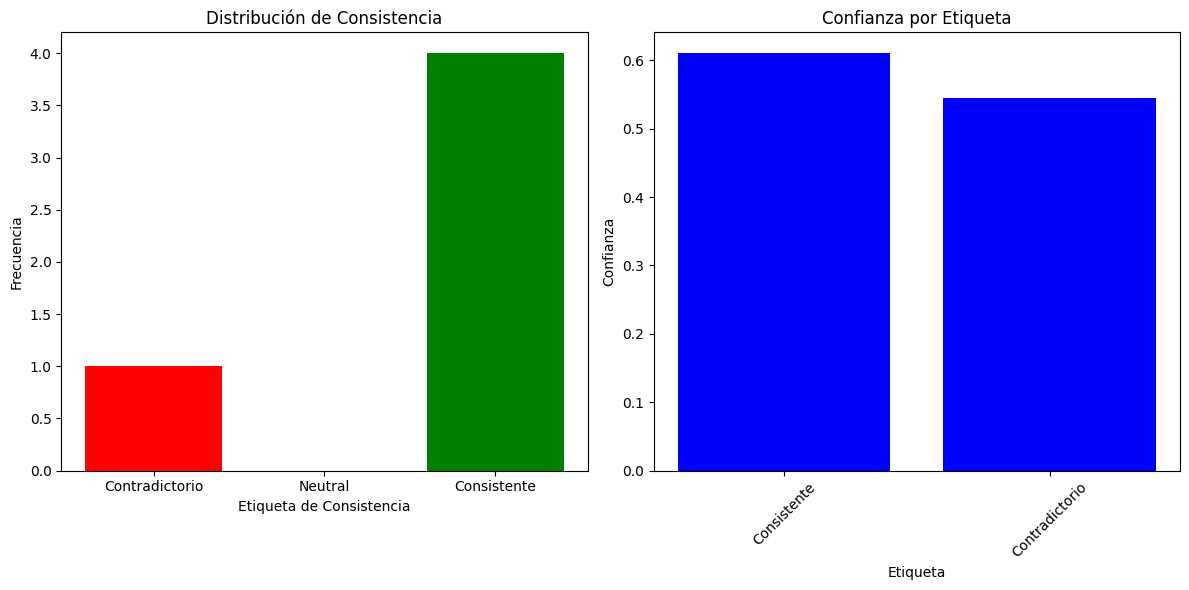

<ipython-input-9-d046e3ead51d>:210: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


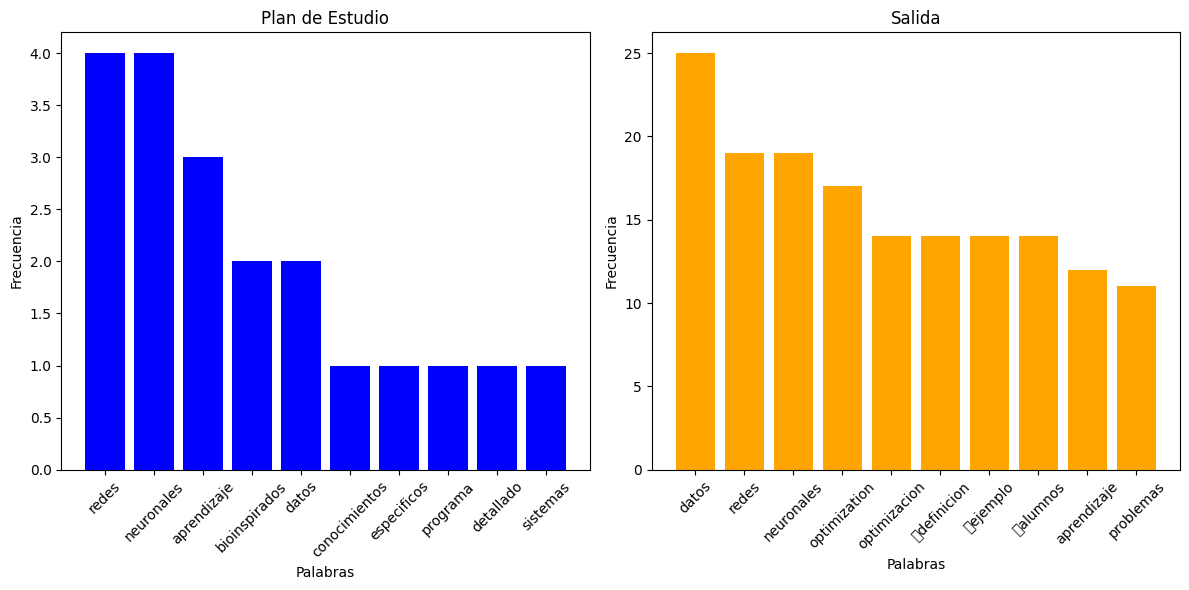

<ipython-input-9-d046e3ead51d>:242: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


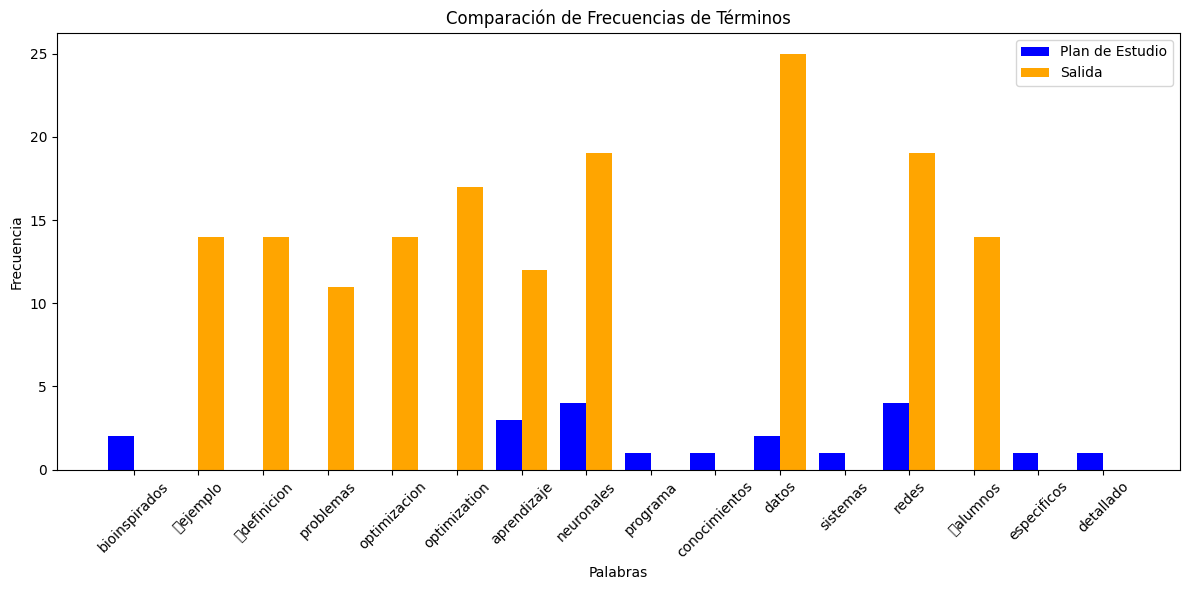

Similitud Semántica Promedio: 53.3671627442042
Resultados de Consistencia: [{'label': 'LABEL_2', 'score': 0.4693448543548584}, {'label': 'LABEL_2', 'score': 0.4903360903263092}, {'label': 'LABEL_2', 'score': 0.6103674173355103}, {'label': 'LABEL_2', 'score': 0.49495768547058105}, {'label': 'LABEL_0', 'score': 0.54508376121521}]


In [9]:
# Requerimientos de librerías
# Instalar con: pip install transformers sentence-transformers torch pypdf2 python-docx

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
from PyPDF2 import PdfReader
from docx import Document
import re
import matplotlib.pyplot as plt
import unicodedata
import string
from collections import Counter
import numpy as np
import io
import nltk
from nltk.corpus import stopwords
import ipywidgets as widgets
from IPython.display import display

# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Obtener stopwords en español e inglés
stop_words = set(stopwords.words('spanish') + stopwords.words('english'))

# Cargar modelos preentrenados
similarity_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
nli_model_name = "textattack/roberta-base-MNLI"
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name)
nli_pipeline = pipeline("text-classification", model=nli_model, tokenizer=nli_tokenizer, truncation=True)

# Widgets para subir archivos (ahora acepta .txt, .pdf y .docx)
upload_plan = widgets.FileUpload(accept='.txt,.pdf,.docx', multiple=False)
upload_salida = widgets.FileUpload(accept='.txt,.pdf,.docx', multiple=False)

# Mostrar widgets
display(widgets.Label('Sube el archivo del Plan de Estudio (.txt, .pdf, .docx):'), upload_plan)
display(widgets.Label('Sube el archivo de Salida (.txt, .pdf, .docx):'), upload_salida)

def process_files():
    global plan_estudio_text, salida_text

    # Leer archivo del plan de estudio
    if upload_plan.value:
        uploaded_plan = list(upload_plan.value.values())[0]
        plan_estudio_text = extract_text(uploaded_plan['content'], uploaded_plan['metadata']['name'])
    else:
        print("Por favor, sube el archivo del plan de estudio.")
        return

    # Leer archivo de salida
    if upload_salida.value:
        uploaded_salida = list(upload_salida.value.values())[0]
        salida_text = extract_text(uploaded_salida['content'], uploaded_salida['metadata']['name'])
    else:
        print("Por favor, sube el archivo de salida.")
        return

    # Normalizar textos
    plan_estudio_text_norm = normalize_text(plan_estudio_text)
    salida_text_norm = normalize_text(salida_text)

    # Comparar relevancia y consistencia
    similarity_score = semantic_similarity(plan_estudio_text_norm, salida_text_norm)
    nli_results = check_consistency(plan_estudio_text, salida_text)
    plot_consistency_results(nli_results)

    # Obtener términos más comunes
    common_words_plan = get_most_common_words(plan_estudio_text_norm, n=10)
    common_words_salida = get_most_common_words(salida_text_norm, n=10)

    # Graficar términos más comunes
    plot_common_words_separately(common_words_plan, common_words_salida, "Plan de Estudio", "Salida")
    plot_common_words_together(common_words_plan, common_words_salida, "Plan de Estudio", "Salida")

    # Mostrar resultados
    print("Similitud Semántica Promedio:", similarity_score)
    print("Resultados de Consistencia:", nli_results)

# Función para extraer texto de archivos .txt, .pdf y .docx
def extract_text(file_content, filename):
    extension = filename.split('.')[-1].lower()

    if extension == 'txt':
        return file_content.decode('utf-8')
    elif extension == 'pdf':
        return extract_text_from_pdf(io.BytesIO(file_content))
    elif extension == 'docx':
        return extract_text_from_docx(io.BytesIO(file_content))
    else:
        print(f"Formato de archivo {extension} no soportado.")
        return ""

# Extraer texto de PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    return "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])

# Extraer texto de DOCX
def extract_text_from_docx(docx_path):
    doc = Document(docx_path)
    return "\n".join([para.text for para in doc.paragraphs])

# Normalizar texto
def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 1]
    text = " ".join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Dividir texto en fragmentos con límite de tokens
def split_text(text, max_length=512):
    words = text.split()
    return [" ".join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

# Calcular similitud semántica promedio
def semantic_similarity(text1, text2):
    chunks1 = split_text(text1, max_length=128)
    chunks2 = split_text(text2, max_length=128)
    similarities = []

    for chunk1 in chunks1:
        for chunk2 in chunks2:
            emb1 = similarity_model.encode(chunk1, convert_to_tensor=True)
            emb2 = similarity_model.encode(chunk2, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(emb1, emb2).item()
            similarities.append(similarity)

    return (sum(similarities) / len(similarities)) * 100 if similarities else 0

# Verificación de consistencia con fragmentos pequeños
def check_consistency(text1, text2):
    chunks1 = split_text(text1, max_length=250)
    chunks2 = split_text(text2, max_length=250)
    results = []

    for chunk1 in chunks1[:5]:
        for chunk2 in chunks2[:5]:
            result = nli_pipeline({"text": chunk1, "text_pair": chunk2})
            results.append(result)

    return results

# Graficar resultados de consistencia
def plot_consistency_results(results):
    LABEL_MAPPING = {
        "LABEL_0": "Contradictorio",
        "LABEL_1": "Neutral",
        "LABEL_2": "Consistente"
    }

    labels = [LABEL_MAPPING[res["label"]] for res in results]
    scores = [res["score"] for res in results]
    label_counts = {label: labels.count(label) for label in LABEL_MAPPING.values()}

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(label_counts.keys(), label_counts.values(), color=['red', 'gray', 'green'])
    plt.xlabel("Etiqueta de Consistencia")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de Consistencia")

    plt.subplot(1, 2, 2)
    plt.bar(labels, scores, color=['blue'])
    plt.xlabel("Etiqueta")
    plt.ylabel("Confianza")
    plt.title("Confianza por Etiqueta")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Obtener términos más comunes
def get_most_common_words(text, n=10):
    words = text.split()
    counter = Counter(words)
    return counter.most_common(n)

# Graficar términos más comunes
def plot_common_words_separately(word_counts1, word_counts2, title1, title2):
    words1, counts1 = zip(*word_counts1)
    words2, counts2 = zip(*word_counts2)

    plt.figure(figsize=(12, 6))

    # Primera gráfica
    plt.subplot(1, 2, 1)
    plt.bar(words1, counts1, color='blue')
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.title(title1)
    plt.xticks(rotation=45)

    # Segunda gráfica
    plt.subplot(1, 2, 2)
    plt.bar(words2, counts2, color='orange')
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.title(title2)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_common_words_together(word_counts1, word_counts2, title1, title2):
    words1, counts1 = zip(*word_counts1)
    words2, counts2 = zip(*word_counts2)

    # Unir las palabras de ambos conjuntos sin repetir
    all_words = list(set(words1) | set(words2))

    # Crear diccionarios para acceso rápido a los conteos
    counts_dict1 = dict(word_counts1)
    counts_dict2 = dict(word_counts2)

    # Obtener los valores de frecuencia alineados
    values1 = [counts_dict1.get(word, 0) for word in all_words]
    values2 = [counts_dict2.get(word, 0) for word in all_words]

    x = np.arange(len(all_words))  # Posiciones en el eje X

    plt.figure(figsize=(12, 6))

    # Gráfico de barras en paralelo
    width = 0.4  # Ancho de las barras
    plt.bar(x - width/2, values1, width=width, color='blue', label=title1)
    plt.bar(x + width/2, values2, width=width, color='orange', label=title2)

    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.title("Comparación de Frecuencias de Términos")
    plt.xticks(ticks=x, labels=all_words, rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.show()

# Botón para procesar archivos
button_process = widgets.Button(description="Procesar Archivos")
button_process.on_click(lambda _: process_files())
display(button_process)
